In [1]:
# pytorch extracting features from the pytorch network
# https://discuss.pytorch.org/t/how-to-extract-features-of-an-image-from-a-trained-model/119/8
# total variational loss explanation
# https://towardsdatascience.com/pytorch-implementation-of-perceptual-losses-for-real-time-style-transfer-8d608e2e9902

from torchvision.models import vgg
from torch import nn

In [2]:
model = vgg.vgg19(pretrained =True)

In [3]:
import gc
import torch
import six
import ctypes
def memReport():
    count = 0
    total_size =0
    for obj in gc.get_objects():
        
        if torch.is_tensor(obj) :
            size = 1
            for dim in obj.size():
                size*=dim
            total_size+=size
            count+=1
        
    total_size /=(256.*1024)        
    #print ("Number of objects: {}, size: {} Mb".format(count, total_size))        

In [4]:
import os

def save_model (model, path, name):
    """This function saves the pytorch model in more user friendly way
        If the @path directory does not exist it is automatically created
        If the @name file already exists in the @path directory the function does not automatically overrides it
        Unless the user confirms it
    
    """
    if not os.path.isdir(path):
        print ("creating directory {}".format(path))
        os.mkdir(path)
     
    if name[-3:].lower()!='.pt':
        name = name + '.pt'
    name_ = os.path.join(path, name)
    
    if os.path.isfile(name_):
        
        conf = input("The file you specified: {} Already exists. Please confirm you want to overwrite it by typing 'y'. Or enter new file name".format(name))
        if conf.lower() == 'y':
            print ("Overwriting {}".format(name))
            torch.save(model.state_dict(), name_)
        elif conf[-3:].lower() == '.pt': 
            save_model(model, path, conf)
        elif len(conf) >0:
            save_model(model, path, conf+'.pt')
        else:
            print ("You entered badly formatted name")
            save_model(model, path, 'default.pt')
    else:
        print ("Saving {}".format(name))
        torch.save(model.state_dict(), name_)
        

In [5]:
#model = nn.Module(model.features)
for module in model.features:
    print (module)

Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
ReLU(inplace)
Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
ReLU(inplace)
MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
ReLU(inplace)
Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
ReLU(inplace)
MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
ReLU(inplace)
Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
ReLU(inplace)
Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
ReLU(inplace)
Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
ReLU(inplace)
MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
ReLU(inplace)
Conv2d(512, 512, kernel_size=(3, 3), stride

In [6]:
import torch
use_gpu = torch.cuda.is_available()
if use_gpu:
    model.cuda()
model.eval()
print (use_gpu)
print (model.features)


True
Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace)
  (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (17): ReLU(inplace)
  (18): MaxPool2d(kernel_size=2, stride=2, paddin

In [7]:
names = ['conv11', 'relu11', 'conv12', 'relu12', 'maxpool1', 
     'conv21', 'relu21', 'conv22','relu22', 'maxpool2',
      'conv31', 'relu31', 'conv32','relu32', 'conv33', 'relu33', 'conv34','relu34','maxpool3',
      'conv41', 'relu41', 'conv42','relu42', 'conv43', 'relu43', 'conv44','relu44','maxpool4',
      'conv51', 'relu51', 'conv52','relu52', 'conv53', 'relu53', 'conv54','relu54','maxpool5',
       ]
style = ['relu12', 'relu22', 'relu33', 'relu43', 'relu54']
content = ['relu43']


In [8]:
import torch.nn as nn
import torch.nn.functional as F
class SelectiveSequential(nn.Module):
    def __init__(self, to_select, modules_dict):
        super(SelectiveSequential, self).__init__()
        for key, module in zip (names, modules_dict):
            self.add_module(key, module)
        self._to_select = to_select
        
    
    def forward(self, x):
        list = []
        for name, module in self._modules.items():
            #print("here")
            x = module(x)
            #print (x)
            if name in self._to_select:
                #print (name)
                list.append(x)
        return list

In [9]:
class Net(nn.Module):
    def __init__(self, select):
        super(Net, self).__init__()
        self.features = SelectiveSequential(
            select,
            model.features
        )

    def forward(self, x):
        return self.features(x)

In [10]:
class Generator (nn.Module):
    def __init__(self):
        super (Generator, self).__init__()
        #num_features1 = 32
        #num_channels =3
        self.conv1 = nn.Conv2d(3, 32, 9, 1, padding =4)
        self.inst1= nn.InstanceNorm2d(32,affine = True)
        self.conv2 = nn.Conv2d(32, 64, 3, 2, padding = 1)
        self.inst2= nn.InstanceNorm2d(64,affine = True)
        self.conv3 = nn.Conv2d(64,128, 3,2, padding = 1)
        self.inst3= nn.InstanceNorm2d(128,affine = True)
        self.resid10 = nn.Conv2d(128,128,3,1, padding =1)
        self.res10= nn.InstanceNorm2d(128,affine = True)
        self.resid11 = nn.Conv2d(128,128,3,1, padding =1)
        self.res11= nn.InstanceNorm2d(128,affine = True)
        self.resid20 = nn.Conv2d(128,128,3,1, padding =1)
        self.res20= nn.InstanceNorm2d(128,affine = True)
        self.resid21 = nn.Conv2d(128,128,3,1, padding =1)
        self.res21= nn.InstanceNorm2d(128,affine = True)
        self.resid30 = nn.Conv2d(128,128,3,1, padding =1)
        self.res30= nn.InstanceNorm2d(128,affine = True)
        self.resid31 = nn.Conv2d(128,128,3,1, padding =1)
        self.res31= nn.InstanceNorm2d(128,affine = True)
        self.resid40 = nn.Conv2d(128,128,3,1, padding =1)
        self.res40= nn.InstanceNorm2d(128,affine = True)
        self.resid41 = nn.Conv2d(128,128,3,1, padding =1)
        self.res41= nn.InstanceNorm2d(128,affine = True)
        self.resid50 = nn.Conv2d(128,128,3,1, padding =1)
        self.res50= nn.InstanceNorm2d(128,affine = True)
        self.resid51 = nn.Conv2d(128,128,3,1, padding =1)
        self.res51= nn.InstanceNorm2d(128,affine = True)
        self.conv_t1 = nn.ConvTranspose2d(128, 64, 3, stride=2, padding=1, output_padding=1)
        self.con1 = nn.InstanceNorm2d(64,affine = True)
        self.conv_t2 = nn.ConvTranspose2d(64, 32, 3, stride=2, padding=1, output_padding=1)
        self.con2 = nn.InstanceNorm2d(32,affine = True)
        self.conv_t3 = nn.Conv2d(32, 3, 9, stride=1, padding=4)
        self.con3 = nn.InstanceNorm2d(3,affine = True)
        
        
        
    def _conv_layer(self, x, layer, norm, relu=True):
        
        x = layer(x)
        x = norm(x)
        if relu:
            x = F.relu(x)
        return x
    
    def _resid_layer(self, x, l1, l2, n1, n2):
        x1 = self._conv_layer(x,l1, n1)
        x1 = self._conv_layer(x1,l2, n2, relu = False)
        
        return x+x1
    
    def _conv_transp_layer(self, x, layer, norm):
        x = layer(x)
        x = norm(x)
        x = F.relu(x)
        return x
    
    
        
   

    def forward(self, x):
        x = self._conv_layer(x,self.conv1, self.inst1)
        x = self._conv_layer(x,self.conv2, self.inst2)
        x = self._conv_layer(x,self.conv3, self.inst3)
        x = self._resid_layer(x, self.resid10, self.resid11, self.res10, self.res11)
        x = self._resid_layer(x, self.resid20, self.resid21, self.res20, self.res21)
        x = self._resid_layer(x, self.resid30, self.resid31, self.res30, self.res31)
        x = self._resid_layer(x, self.resid40, self.resid41, self.res40, self.res41)
        x = self._resid_layer(x, self.resid50, self.resid51, self.res50, self.res51)
        x = self._conv_transp_layer(x, self.conv_t1, self.con1)
        x = self._conv_transp_layer(x, self.conv_t2, self.con2)
        x = self._conv_layer(x, self.conv_t3, self.con3, relu = False)
        x = F.sigmoid(x)
        return x
    
        

In [11]:
def gram (feature_maps):
    #print (feature_maps)
    (b,ch,h,w) = feature_maps.size()
    #print (b,ch,h,w)
    vector_map = feature_maps.view(b,ch, h*w)
    #print (vector)
    vector_map_T = vector_map.transpose(1,2)
    gram = torch.bmm (vector_map, vector_map_T)/(ch*h*w)
    return gram

In [12]:
from torch.optim import Adam

def retrain(content_targets, style_target, content_weight = 1, style_weight = 1000, tv_weight_l1= 0,
             tv_weight_l2 = 0, batch_size = 1, learning_rate =.001, epochs = 1, old_model = 'standard500_l1_d01_c3.pt', model_name = 'default.pt'):
    
    
    use_gpu = torch.cuda.is_available()
    
    if tv_weight_l2 != 0:
        tv2_loss_x = torch.sum((style_target[:, :, :, :-1] - style_target[:, :, :, 1:])**2)
        tv2_loss_y = torch.sum((style_target[:, :, :-1, :] - style_target[:, :, 1:, :])**2 )
        tv_weight_l2 = tv_weight_l2/(tv2_loss_x + tv2_loss_y)
    if tv_weight_l1 !=0:
        tv_loss_x =  torch.sum(torch.abs(style_target[:, :, :, :-1] - style_target[:, :, :, 1:]))
        tv_loss_y = torch.sum(torch.abs(style_target[:, :, :-1, :] - style_target[:, :, 1:, :]))
        tv_weight_l1 = tv_weight_l1/(tv_loss_x + tv_loss_y)
    
    #print (style)
    stl = Net(style)
    transform = Generator()
    model_dir = 'saved_models/'
    
    transform.load_state_dict(torch.load(os.path.join(model_dir, old_model)))
    if use_gpu:
        stl.cuda()
        transform.cuda()
    stl.eval()
    transform.train()
    optimizer = Adam(transform.parameters(), learning_rate)
    mse_loss = torch.nn.MSELoss()

    st_features = stl(style_target)
    #print (st_features.size())
    # gram matrix for style only need to be computed once
    gram_st = [gram(feature) for feature in st_features]
    #print (len(gram_st))
    

    memReport()
    for epoch in range(epochs):
        
        cnt_loss = 0
        st_loss = 0
        tv_l1 = 0
        tv_l2 = 0
        running_loss=0
        count = 0
        for batch, y_c in enumerate(content_targets):
            #y_c = data['image']
            
            n_batch = len(y_c)
            
            optimizer.zero_grad()
            memReport()
            
            if use_gpu:
                y_c = y_c.cuda()

            y_t = transform(y_c)
            
            memReport()
            features_yt = stl(y_t)
            #for feature in features_yt:
            #    feature.requres_grad = False
            #features_yt.requres_grad = False
            # y_c is the same is original image)
            features_yc = stl(y_c)
            #for feature in features_yc:
            #    feature.requres_grad = False
            #features_yc.requres_grad = False

            #f_xc_c = Variable(features_xc[1].data, requires_grad=False)
            
            feature = Variable(features_yc[4].data, requires_grad=False)
            #print (feature.size(), features_yt[3].size())
            #print (y_t.size())
            cnt_weight = content_weight / y_t.size()[0]
            content_loss = cnt_weight * mse_loss(features_yt[4], feature)

            style_loss = 0.
            stl_weight = style_weight/y_t.size()[0]
            for m in range(len(gram_st)):
                
                gram_s = Variable(gram_st[m].data, requires_grad=False)
                gram_yt = gram(features_yt[m])
                #print ("gram sizes gram_s, gram_yt", gram_s.size(), gram_yt.size())
                for i in range (n_batch):
                    style_loss += stl_weight * mse_loss(gram_yt[i:i+1,:,:], gram_s)
            
            tv_w1 = tv_weight_l1/y_t.size()[0]
            
            if tv_weight_l1 != 0:
                tv_loss_l1 = tv_w1* (torch.sum(torch.abs(y_t[:, :, :, :-1] - y_t[:, :, :, 1:])) + 
                torch.sum(torch.abs(y_t[:, :, :-1, :] - y_t[:, :, 1:, :])))
            else:
                tv_loss_l1 = torch.Tensor([0])
                if use_gpu:
                    tv_loss_l1 = tv_loss_l1.type(torch.cuda.FloatTensor)
                    
                    
            tv_w2 = tv_weight_l2/y_t.size()[0]        
            if tv_weight_l2 !=0:
                tv_loss_l2 = tv_w2* (torch.sum((y_t[:, :, :, :-1] - y_t[:, :, :, 1:])**2) + 
                torch.sum((y_t[:, :, :-1, :] - y_t[:, :, 1:, :]))**2)
            else:
                tv_loss_l2 = torch.Tensor([0])
                if use_gpu:
                    tv_loss_l2 = tv_loss_l2.type(torch.cuda.FloatTensor)
               
           
                
            total_loss = content_loss + style_loss + tv_loss_l1+ tv_loss_l2
            total_loss.backward()
            optimizer.step()

            running_loss += total_loss[0]
            cnt_loss += content_loss[0]
            st_loss += style_loss[0]
            tv_l1 += tv_loss_l1[0]
            tv_l2 += tv_loss_l2[0]
            
            print_every = 10
            if batch % print_every == print_every-1:    # print every 10 batches
                print('Epoch: {}, Batch: {}, Avg. Loss: {}, Content_loss: {}, Style_loss: {}, l1: {}, l2: {}'
                      .format(epoch + 1, batch+1, running_loss/print_every, cnt_loss, st_loss, tv_l1, tv_l2))
                running_loss = 0.0
                cnt_loss = 0
                st_loss = 0
                tv_l1 = 0
                tv_l2 = 0
    print('Finished Training')
    
    

    # after training, save your model parameters in the dir 'saved_models'
    #torch.save(transform.state_dict(), model_dir+model_name)
    save_model (transform, model_dir, model_name)    
    del stl
    del transform


In [13]:
from torch.optim import Adam

def train(content_targets, style_target, content_weight = 1, style_weight = 1000, tv_weight_l1= 0,
             tv_weight_l2 = 0, batch_size = 2, learning_rate =.001, epochs = 2, model_name = 'default.pt'):
    
    
    use_gpu = torch.cuda.is_available()
    
    if tv_weight_l2 != 0:
        tv2_loss_x = torch.sum((style_target[:, :, :, :-1] - style_target[:, :, :, 1:])**2)
        tv2_loss_y = torch.sum((style_target[:, :, :-1, :] - style_target[:, :, 1:, :])**2 )
        tv_weight_l2 = tv_weight_l2/(tv2_loss_x + tv2_loss_y)
    if tv_weight_l1 !=0:
        tv_loss_x =  torch.sum(torch.abs(style_target[:, :, :, :-1] - style_target[:, :, :, 1:]))
        tv_loss_y = torch.sum(torch.abs(style_target[:, :, :-1, :] - style_target[:, :, 1:, :]))
        tv_weight_l1 = tv_weight_l1/(tv_loss_x + tv_loss_y)
    
    #print (style)
    stl = Net(style)
    transform = Generator()
    if use_gpu:
        stl.cuda()
        transform.cuda()
    stl.eval()
    transform.train()
    optimizer = Adam(transform.parameters(), learning_rate)
    mse_loss = torch.nn.MSELoss()

    st_features = stl(style_target)
    #print (st_features.size())
    # gram matrix for style only need to be computed once
    gram_st = [gram(feature) for feature in st_features]
    #print (len(gram_st))
    

    memReport()
    for epoch in range(epochs):
        
        cnt_loss = 0
        st_loss = 0
        tv_l1 = 0
        tv_l2 = 0
        running_loss=0
        count = 0
        for batch, y_c in enumerate(content_targets):
            #y_c = data['image']
            
            n_batch = len(y_c)
            
            optimizer.zero_grad()
            memReport()
            
            if use_gpu:
                y_c = y_c.cuda()

            y_t = transform(y_c)
            
            memReport()
            features_yt = stl(y_t)
            #for feature in features_yt:
            #    feature.requres_grad = False
            #features_yt.requres_grad = False
            # y_c is the same is original image)
            features_yc = stl(y_c)
            #for feature in features_yc:
            #    feature.requres_grad = False
            #features_yc.requres_grad = False

            #f_xc_c = Variable(features_xc[1].data, requires_grad=False)
            
            feature = Variable(features_yc[3].data, requires_grad=False)
            #print (feature.size(), features_yt[3].size())
            #print (y_t.size())
            cnt_weight = content_weight / y_t.size()[0]
            content_loss = cnt_weight * mse_loss(features_yt[3], feature)

            style_loss = 0.
            stl_weight = style_weight/y_t.size()[0]
            for m in range(len(gram_st)):
                
                gram_s = Variable(gram_st[m].data, requires_grad=False)
                gram_yt = gram(features_yt[m])
                #print ("gram sizes gram_s, gram_yt", gram_s.size(), gram_yt.size())
                for i in range (n_batch):
                    style_loss += stl_weight * mse_loss(gram_yt[i:i+1,:,:], gram_s)
            
            tv_w1 = tv_weight_l1/y_t.size()[0]
            
            if tv_weight_l1 != 0:
                tv_loss_l1 = tv_w1* (torch.sum(torch.abs(y_t[:, :, :, :-1] - y_t[:, :, :, 1:])) + 
                torch.sum(torch.abs(y_t[:, :, :-1, :] - y_t[:, :, 1:, :])))
            else:
                tv_loss_l1 = torch.Tensor([0])
                if use_gpu:
                    tv_loss_l1 = tv_loss_l1.type(torch.cuda.FloatTensor)
                    
                    
            tv_w2 = tv_weight_l2/y_t.size()[0]        
            if tv_weight_l2 !=0:
                tv_loss_l2 = tv_w2* (torch.sum((y_t[:, :, :, :-1] - y_t[:, :, :, 1:])**2) + 
                torch.sum((y_t[:, :, :-1, :] - y_t[:, :, 1:, :]))**2)
            else:
                tv_loss_l2 = torch.Tensor([0])
                if use_gpu:
                    tv_loss_l2 = tv_loss_l2.type(torch.cuda.FloatTensor)
               
           
                
            total_loss = content_loss + style_loss + tv_loss_l1+ tv_loss_l2
            total_loss.backward()
            optimizer.step()

            running_loss += total_loss[0]
            cnt_loss += content_loss[0]
            st_loss += style_loss[0]
            tv_l1 += tv_loss_l1[0]
            tv_l2 += tv_loss_l2[0]
            
            print_every = 10
            if batch % print_every == print_every-1:    # print every 10 batches
                print('Epoch: {}, Batch: {}, Avg. Loss: {}, Content_loss: {}, Style_loss: {}, l1: {}, l2: {}'
                      .format(epoch + 1, batch+1, running_loss/print_every, cnt_loss, st_loss, tv_l1, tv_l2))
                running_loss = 0.0
                cnt_loss = 0
                st_loss = 0
                tv_l1 = 0
                tv_l2 = 0
    print('Finished Training')
    model_dir = 'saved_models/'
    

    # after training, save your model parameters in the dir 'saved_models'
    #torch.save(transform.state_dict(), model_dir+model_name)
    save_model (transform, model_dir, model_name)    
    del stl
    del transform


In [14]:
from torchvision import transforms, utils
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt

# the dataset 
#from data_load import StyleTransferDataset


# define the data_transform using transforms.Compose([all tx's, . , .])
# order matters! i.e. rescaling should come before a smaller crop
data_transform = transforms.Compose([transforms.Resize(300),
                                     transforms.RandomCrop(256),
                                     transforms.ToTensor()
                                     #transforms.Normalize([0.48462227599918, 0.45624044862054, 0.40588363755159],
                                     #                    [0.22889466674951, 0.22446679341259, 0.22495548344775])
                                     ])

In [15]:
from data_load import *
transformed_dataset = StyleTransferDataset(root_dir='data/training/',
                                             transform=data_transform)

0 torch.Size([3, 256, 256])
(3, 256, 256)
(256, 256, 3)


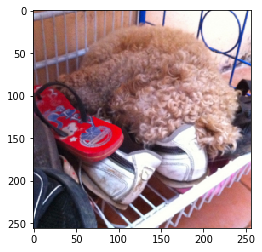

1 torch.Size([3, 256, 256])
(3, 256, 256)
(256, 256, 3)


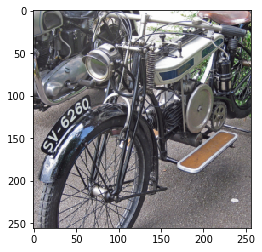

2 torch.Size([3, 256, 256])
(3, 256, 256)
(256, 256, 3)


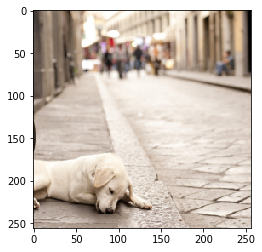

3 torch.Size([3, 256, 256])
(3, 256, 256)
(256, 256, 3)


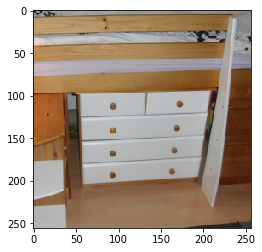

In [16]:
for i in range(4):
    sample = transformed_dataset[i]
    print(i, sample.size())
    
    #print(sample)
    im = sample.numpy()
    print (im.shape)
    #print (im.shape)
    im = im.transpose(1,2,0)
    print (im.shape)
    
    #print (im.shape)
    plt.imshow(im)
    plt.show()

In [17]:
batch_size = 10

train_loader = DataLoader(transformed_dataset, 
                          batch_size=batch_size,
                          shuffle=True, 
                          num_workers=0)

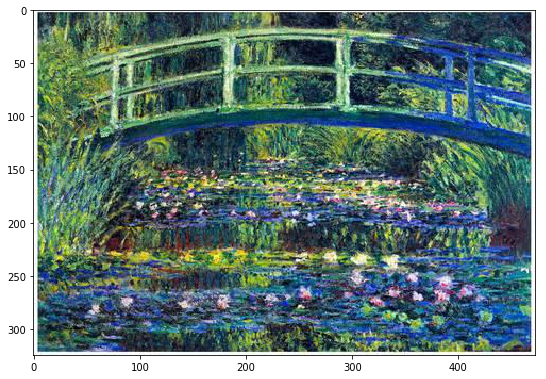

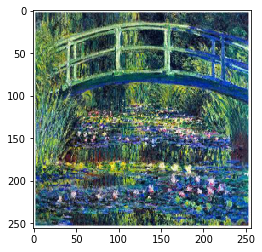

In [18]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import torch
from torch.autograd import Variable

use_gpu = torch.cuda.is_available()

style_im = cv2.imread('data/style/waterlily.jpg')


#print (image)
style_im = cv2.cvtColor(style_im, cv2.COLOR_BGR2RGB)

fig = plt.figure(figsize=(9,9))
plt.imshow(style_im)
plt.imshow(style_im)
plt.show()

#image preprocessing

style_im = cv2.resize(style_im,(256,256))
style_im = style_im/255
plt.imshow(style_im)
plt.show()
style_im = np.transpose(style_im, (2,0,1))
style_im = np.expand_dims(style_im, axis= 0) #batch size 1


# plot the image


trch = torch.from_numpy(style_im)
if (use_gpu):
    trch = trch.type(torch.cuda.FloatTensor)
else:
    trch = trch.type(torch.FloatTensor)
trch = Variable(trch)



In [19]:
def schedule(run = 0, cnst = 0):
    model_name = 'standard' + str(run + cnst) + '.pt'
    if run + cnst == 0:
        tv_weight1 = 0
        tv_weight2 = 0
    elif run + cnst == 1:
        tv_weight1 = 1
        tv_weight2 = 0
    elif run +cnst == 2:
        tv_weight1 = 5
        tv_weight2 = 0
    elif run +cnst ==3:
        tv_weight1 = 10
        tv_weight2 = 0
    elif run + cnst == 4:
        tv_weight1 = 20
        tv_weight2 = 0
    elif run + cnst == 5:
        tv_weight1 = 0
        tv_weight2 = 1
    elif run + cnst == 6:
        tv_weight1 = 0
        tv_weight2 = 5
    elif run + cnst == 7:
        tv_weight1 = 0
        tv_weight2 = 10
    else:#if run + cnst == 8:
        tv_weight1 = 0
        tv_weight2 = 20
    return model_name, tv_weight1, tv_weight2
def schedule1 (run = 0):
    if run ==0:
        style_weight = 100
    elif run == 1:
        style_weight = 500
    elif run == 2:
        style_weight = 1000
    elif run == 3:
        style_weight = 3000
    elif run== 4:
        style_weight = 10000
    else:
        style_weight = 100000
    return style_weight        

model_name, tv_weight1, tv_weight2 = schedule (0,0)
stl_wgt = schedule1(4)

In [42]:
print (model_name, tv_weight1, tv_weight2, stl_wgt)

retrain20000_l2_d01_c4_o10000.pt 0 0.01 20000


In [41]:
model_name = 'retrain20000_l2_d01_c4_o10000.pt'
stl_wgt = 20000
tv_weight2 = .01
old_model = 'retrain10000_l2_d01_c4_o2000.pt'

In [43]:
retrain(train_loader,trch, style_weight = stl_wgt, tv_weight_l1 = tv_weight1, tv_weight_l2 = tv_weight2, model_name = model_name, old_model = old_model)

C:\ProgramData\Anaconda3\envs\torch\lib\site-packages\ipykernel_launcher.py:117: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
C:\ProgramData\Anaconda3\envs\torch\lib\site-packages\ipykernel_launcher.py:118: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
C:\ProgramData\Anaconda3\envs\torch\lib\site-packages\ipykernel_launcher.py:120: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Epoch: 1, Batch: 10, Avg. Loss: 0.04432497173547745, Content_loss: 0.19538629055023193, Style_loss: 0.20772823691368103, l1: 0.0, l2: 0.040135156363248825
Epoch: 1, Batch: 20, Avg. Loss: 0.0377981923520565, Content_loss: 0.19156256318092346, Style_loss: 0.14762449264526367, l1: 0.0, l2: 0.038794852793216705
Epoch: 1, Batch: 30, Avg. Loss: 0.03509274870157242, Content_loss: 0.19235992431640625, Style_loss: 0.12030860781669617, l1: 0.0, l2: 0.038258932530879974
Epoch: 1, Batch: 40, Avg. Loss: 0.0352749302983284, Content_loss: 0.19767259061336517, Style_loss: 0.11681277304887772, l1: 0.0, l2: 0.03826390579342842
Epoch: 1, Batch: 50, Avg. Loss: 0.035419072955846786, Content_loss: 0.2054673433303833, Style_loss: 0.11060743033885956, l1: 0.0, l2: 0.03811589628458023
Epoch: 1, Batch: 60, Avg. Loss: 0.03482015058398247, Content_loss: 0.19803762435913086, Style_loss: 0.11199997365474701, l1: 0.0, l2: 0.038163866847753525
Epoch: 1, Batch: 70, Avg. Loss: 0.03393708914518356, Content_loss: 0.18785

Epoch: 1, Batch: 540, Avg. Loss: 0.03286914527416229, Content_loss: 0.19220410287380219, Style_loss: 0.09778238087892532, l1: 0.0, l2: 0.038704968988895416
Epoch: 1, Batch: 550, Avg. Loss: 0.032727696001529694, Content_loss: 0.1877017468214035, Style_loss: 0.10065717995166779, l1: 0.0, l2: 0.03891805186867714
Epoch: 1, Batch: 560, Avg. Loss: 0.03306223079562187, Content_loss: 0.19297276437282562, Style_loss: 0.09932337701320648, l1: 0.0, l2: 0.038326162844896317
Epoch: 1, Batch: 570, Avg. Loss: 0.03330144286155701, Content_loss: 0.1942938268184662, Style_loss: 0.10002513974905014, l1: 0.0, l2: 0.03869544714689255
Epoch: 1, Batch: 580, Avg. Loss: 0.032317548990249634, Content_loss: 0.18803416192531586, Style_loss: 0.0965379849076271, l1: 0.0, l2: 0.03860335424542427
Epoch: 1, Batch: 590, Avg. Loss: 0.03433021530508995, Content_loss: 0.2078484296798706, Style_loss: 0.09677322208881378, l1: 0.0, l2: 0.038680464029312134
Epoch: 1, Batch: 600, Avg. Loss: 0.033697303384542465, Content_loss: 

Epoch: 1, Batch: 1070, Avg. Loss: 0.034411367028951645, Content_loss: 0.20939165353775024, Style_loss: 0.09571941196918488, l1: 0.0, l2: 0.039002567529678345
Epoch: 1, Batch: 1080, Avg. Loss: 0.03331613168120384, Content_loss: 0.19949690997600555, Style_loss: 0.09487645328044891, l1: 0.0, l2: 0.03878796845674515
Epoch: 1, Batch: 1090, Avg. Loss: 0.03253937140107155, Content_loss: 0.192892387509346, Style_loss: 0.09371785074472427, l1: 0.0, l2: 0.0387834757566452
Epoch: 1, Batch: 1100, Avg. Loss: 0.032721634954214096, Content_loss: 0.19329969584941864, Style_loss: 0.09528600424528122, l1: 0.0, l2: 0.038630641996860504
Epoch: 1, Batch: 1110, Avg. Loss: 0.03252707049250603, Content_loss: 0.19318285584449768, Style_loss: 0.09317290782928467, l1: 0.0, l2: 0.03891490027308464
Epoch: 1, Batch: 1120, Avg. Loss: 0.033486928790807724, Content_loss: 0.19994984567165375, Style_loss: 0.09614730626344681, l1: 0.0, l2: 0.038772135972976685
Epoch: 1, Batch: 1130, Avg. Loss: 0.03236156329512596, Conten

Epoch: 1, Batch: 1600, Avg. Loss: 0.03250927850604057, Content_loss: 0.1938147395849228, Style_loss: 0.09235423803329468, l1: 0.0, l2: 0.03892377391457558
Epoch: 1, Batch: 1610, Avg. Loss: 0.03241313621401787, Content_loss: 0.194471076130867, Style_loss: 0.09094678610563278, l1: 0.0, l2: 0.03871353715658188
Epoch: 1, Batch: 1620, Avg. Loss: 0.03340982645750046, Content_loss: 0.19959843158721924, Style_loss: 0.09551459550857544, l1: 0.0, l2: 0.03898521140217781
Epoch: 1, Batch: 1630, Avg. Loss: 0.032472021877765656, Content_loss: 0.19590811431407928, Style_loss: 0.09013501554727554, l1: 0.0, l2: 0.03867705166339874
Epoch: 1, Batch: 1640, Avg. Loss: 0.03477277606725693, Content_loss: 0.20694950222969055, Style_loss: 0.10201064497232437, l1: 0.0, l2: 0.03876761719584465
Epoch: 1, Batch: 1650, Avg. Loss: 0.0331614650785923, Content_loss: 0.19948528707027435, Style_loss: 0.09333217144012451, l1: 0.0, l2: 0.03879718482494354
Epoch: 1, Batch: 1660, Avg. Loss: 0.0327872596681118, Content_loss:

Epoch: 1, Batch: 2130, Avg. Loss: 0.03224635869264603, Content_loss: 0.19505912065505981, Style_loss: 0.08864279091358185, l1: 0.0, l2: 0.0387616790831089
Epoch: 1, Batch: 2140, Avg. Loss: 0.032758455723524094, Content_loss: 0.1950414627790451, Style_loss: 0.09364396333694458, l1: 0.0, l2: 0.03889916092157364
Epoch: 1, Batch: 2150, Avg. Loss: 0.033421024680137634, Content_loss: 0.20426930487155914, Style_loss: 0.0911966934800148, l1: 0.0, l2: 0.038744211196899414
Epoch: 1, Batch: 2160, Avg. Loss: 0.03220948204398155, Content_loss: 0.19456611573696136, Style_loss: 0.08882995694875717, l1: 0.0, l2: 0.038698773831129074
Epoch: 1, Batch: 2170, Avg. Loss: 0.0328618548810482, Content_loss: 0.19678038358688354, Style_loss: 0.09271988272666931, l1: 0.0, l2: 0.039118312299251556
Epoch: 1, Batch: 2180, Avg. Loss: 0.03327886760234833, Content_loss: 0.20404356718063354, Style_loss: 0.09009146690368652, l1: 0.0, l2: 0.0386536531150341
Epoch: 1, Batch: 2190, Avg. Loss: 0.032532572746276855, Content_

Epoch: 1, Batch: 2660, Avg. Loss: 0.030650971457362175, Content_loss: 0.18253758549690247, Style_loss: 0.08536326885223389, l1: 0.0, l2: 0.0386088490486145
Epoch: 1, Batch: 2670, Avg. Loss: 0.03169749304652214, Content_loss: 0.19157859683036804, Style_loss: 0.08666656911373138, l1: 0.0, l2: 0.03872974216938019
Epoch: 1, Batch: 2680, Avg. Loss: 0.03415761515498161, Content_loss: 0.214912548661232, Style_loss: 0.08788168430328369, l1: 0.0, l2: 0.038781944662332535
Epoch: 1, Batch: 2690, Avg. Loss: 0.031139690428972244, Content_loss: 0.1861823946237564, Style_loss: 0.086283840239048, l1: 0.0, l2: 0.03893069550395012
Epoch: 1, Batch: 2700, Avg. Loss: 0.03165525943040848, Content_loss: 0.1937103122472763, Style_loss: 0.08377655595541, l1: 0.0, l2: 0.03906571865081787
Epoch: 1, Batch: 2710, Avg. Loss: 0.0309204813092947, Content_loss: 0.18662117421627045, Style_loss: 0.08380449563264847, l1: 0.0, l2: 0.03877915069460869
Epoch: 1, Batch: 2720, Avg. Loss: 0.03070729412138462, Content_loss: 0.1

Epoch: 1, Batch: 3190, Avg. Loss: 0.032401543110609055, Content_loss: 0.1982426643371582, Style_loss: 0.08681157231330872, l1: 0.0, l2: 0.03896114602684975
Epoch: 1, Batch: 3200, Avg. Loss: 0.031128866598010063, Content_loss: 0.18605662882328033, Style_loss: 0.0863436907529831, l1: 0.0, l2: 0.0388883501291275
Epoch: 1, Batch: 3210, Avg. Loss: 0.0319981686770916, Content_loss: 0.1961253434419632, Style_loss: 0.08502078056335449, l1: 0.0, l2: 0.038835566490888596
Epoch: 1, Batch: 3220, Avg. Loss: 0.03164262697100639, Content_loss: 0.19207875430583954, Style_loss: 0.08566314727067947, l1: 0.0, l2: 0.038684383034706116
Epoch: 1, Batch: 3230, Avg. Loss: 0.033570658415555954, Content_loss: 0.20975133776664734, Style_loss: 0.0872897282242775, l1: 0.0, l2: 0.03866546228528023
Epoch: 1, Batch: 3240, Avg. Loss: 0.03263707086443901, Content_loss: 0.19989348948001862, Style_loss: 0.08754674345254898, l1: 0.0, l2: 0.038930442184209824
Epoch: 1, Batch: 3250, Avg. Loss: 0.031349264085292816, Content_

Epoch: 1, Batch: 3720, Avg. Loss: 0.03069877065718174, Content_loss: 0.18485213816165924, Style_loss: 0.0833469107747078, l1: 0.0, l2: 0.03878866881132126
Epoch: 1, Batch: 3730, Avg. Loss: 0.03282322362065315, Content_loss: 0.2046719342470169, Style_loss: 0.08481978625059128, l1: 0.0, l2: 0.03874048963189125
Epoch: 1, Batch: 3740, Avg. Loss: 0.031176505610346794, Content_loss: 0.18849320709705353, Style_loss: 0.08462723344564438, l1: 0.0, l2: 0.038644611835479736
Epoch: 1, Batch: 3750, Avg. Loss: 0.033025745302438736, Content_loss: 0.20470303297042847, Style_loss: 0.08673332631587982, l1: 0.0, l2: 0.03882109001278877
Epoch: 1, Batch: 3760, Avg. Loss: 0.03141220659017563, Content_loss: 0.19274109601974487, Style_loss: 0.08251585811376572, l1: 0.0, l2: 0.03886513411998749
Epoch: 1, Batch: 3770, Avg. Loss: 0.03162383288145065, Content_loss: 0.1916545033454895, Style_loss: 0.08549155294895172, l1: 0.0, l2: 0.039092227816581726
Epoch: 1, Batch: 3780, Avg. Loss: 0.0318441316485405, Content_l

In [ ]:
style

In [ ]:
print (type (train_loader))
for batch, data in train_loader:
    print (batch)

In [ ]:
from pytorch_modelsize import SizeEstimator
stl = Net(style)
gen = Generator()

if use_gpu:
    stl.cuda()
    gen.cuda()
    
se = SizeEstimator(gen, input_size=(1,3,256,256))
print(se.estimate_size())

# Returns
# (size in megabytes, size in bits)
# (408.2833251953125, 3424928768)

print(se.param_bits) # bits taken up by parameters
print(se.forward_backward_bits) # bits stored for forward and backward
print(se.input_bits) # bits for input

In [ ]:
print (style)

In [ ]:
for module in model.features:
    print (module)

In [ ]:
gen.modules()

In [ ]:
for module in gen.modules():
    print (module)

In [23]:
for i in range (2, len (gen.modules())):
    print (gen.modules[i])
    

TypeError: object of type 'generator' has no len()

In [1]:
import gc
import torch
def memReport():
    for obj in gc.get_objects():
        if torch.is_tensor(obj) or (hasattr(obj, 'data') and torch.is_tensor(obj.data)):
            print(type(obj), obj.size())
            

In [10]:
memReport()

<class 'torch.Tensor'> torch.Size([64, 3, 3, 3])
<class 'torch.Tensor'> torch.Size([64])
<class 'torch.Tensor'> torch.Size([64, 64, 3, 3])
<class 'torch.Tensor'> torch.Size([64])
<class 'torch.Tensor'> torch.Size([128, 64, 3, 3])
<class 'torch.Tensor'> torch.Size([128])
<class 'torch.Tensor'> torch.Size([128, 128, 3, 3])
<class 'torch.Tensor'> torch.Size([128])
<class 'torch.Tensor'> torch.Size([256, 128, 3, 3])
<class 'torch.Tensor'> torch.Size([256])
<class 'torch.Tensor'> torch.Size([256, 256, 3, 3])
<class 'torch.Tensor'> torch.Size([256])
<class 'torch.Tensor'> torch.Size([256, 256, 3, 3])
<class 'torch.Tensor'> torch.Size([256])
<class 'torch.Tensor'> torch.Size([256, 256, 3, 3])
<class 'torch.Tensor'> torch.Size([256])
<class 'torch.Tensor'> torch.Size([512, 256, 3, 3])
<class 'torch.Tensor'> torch.Size([512])
<class 'torch.Tensor'> torch.Size([512, 512, 3, 3])
<class 'torch.Tensor'> torch.Size([512])
<class 'torch.Tensor'> torch.Size([512, 512, 3, 3])
<class 'torch.Tensor'> tor

ModuleNotFoundError: No module named '_gdbm'

In [19]:
tv_loss =  (torch.sum(torch.abs(trch[:, :, :, :-1] - trch[:, :, :, 1:])) + 
            torch.sum(torch.abs(trch[:, :, :-1, :] - trch[:, :, 1:, :])))

In [20]:
tv_loss

tensor(33326.3750, device='cuda:0')

In [23]:
losses = []
for batch, cont in enumerate(train_loader):
    tv_loss = (torch.sum(torch.abs(cont[:, :, :, :-1] - cont[:, :, :, 1:])) + 
            torch.sum(torch.abs(cont[:, :, :-1, :] - cont[:, :, 1:, :])))
    losses.append(tv_loss)
    if batch% 10 == 9:
        print (tv_loss)


tensor(1.00000e+05 *
       1.3096)
tensor(1.00000e+05 *
       1.0339)
tensor(99659.4922)
tensor(1.00000e+05 *
       1.1791)
tensor(95074.6016)
tensor(1.00000e+05 *
       1.5070)
tensor(1.00000e+05 *
       1.1874)
tensor(1.00000e+05 *
       1.2678)
tensor(1.00000e+05 *
       1.5815)
tensor(1.00000e+05 *
       1.1169)
tensor(87956.5703)
tensor(1.00000e+05 *
       1.1867)
tensor(1.00000e+05 *
       1.1499)
tensor(1.00000e+05 *
       1.2708)
tensor(1.00000e+05 *
       1.2554)
tensor(97963.2969)
tensor(1.00000e+05 *
       1.0042)
tensor(1.00000e+05 *
       1.3744)
tensor(1.00000e+05 *
       1.1897)
tensor(1.00000e+05 *
       1.3627)
tensor(1.00000e+05 *
       1.1742)
tensor(91737.0312)
tensor(1.00000e+05 *
       1.3673)
tensor(1.00000e+05 *
       1.3024)
tensor(1.00000e+05 *
       1.0320)
tensor(1.00000e+05 *
       1.2552)
tensor(1.00000e+05 *
       1.0510)
tensor(1.00000e+05 *
       1.3563)
tensor(1.00000e+05 *
       1.4873)
tensor(1.00000e+05 *
       1.7332)
tenso

tensor(1.00000e+05 *
       1.5943)
tensor(1.00000e+05 *
       1.2323)
tensor(1.00000e+05 *
       1.1480)
tensor(1.00000e+05 *
       1.0704)
tensor(1.00000e+05 *
       1.3576)
tensor(1.00000e+05 *
       1.2644)
tensor(1.00000e+05 *
       1.3790)
tensor(1.00000e+05 *
       1.3485)
tensor(1.00000e+05 *
       1.0392)
tensor(1.00000e+05 *
       1.2755)
tensor(1.00000e+05 *
       1.3454)
tensor(1.00000e+05 *
       1.4033)
tensor(1.00000e+05 *
       1.1764)
tensor(85818.2031)
tensor(1.00000e+05 *
       1.1782)
tensor(1.00000e+05 *
       1.2891)
tensor(1.00000e+05 *
       1.2632)
tensor(1.00000e+05 *
       1.3234)
tensor(1.00000e+05 *
       1.1320)
tensor(1.00000e+05 *
       1.2787)
tensor(1.00000e+05 *
       1.2461)
tensor(1.00000e+05 *
       1.1014)
tensor(1.00000e+05 *
       1.4185)
tensor(86978.9062)
tensor(1.00000e+05 *
       1.5916)
tensor(1.00000e+05 *
       1.2073)
tensor(1.00000e+05 *
       1.2337)
tensor(1.00000e+05 *
       1.2883)
tensor(1.00000e+05 *
     

In [27]:
mn = torch.min(torch.FloatTensor(losses))

In [28]:
mn

tensor(37615.5391)

In [29]:
mx = torch.max(torch.FloatTensor(losses))

In [30]:
mx

tensor(1.00000e+05 *
       1.9427)

In [31]:
mean = torch.mean(torch.FloatTensor(losses))

In [32]:
mean

tensor(1.00000e+05 *
       1.2504)

In [33]:
std = torch.std(torch.FloatTensor(losses))

In [34]:
std

tensor(17270.4922)

In [19]:
tv2_loss = (torch.sum((trch[:, :, :, :-1] - trch[:, :, :, 1:])**2) + 
            torch.sum((trch[:, :, :-1, :] - trch[:, :, 1:, :])**2 ))

In [20]:
tv2_loss

Variable containing:
 5553.8936
[torch.FloatTensor of size 1]

In [41]:
losses2 = []
for batch, cont in enumerate(train_loader):
    #print (cont.size())
    tv2_loss = (torch.sum((cont[:, :, :, :-1] - cont[:, :, :, 1:])**2) + 
            torch.sum((cont[:, :, :-1, :] - cont[:, :, 1:, :])**2 ))
    losses2.append(tv_loss)
    if batch% 10 == 9:
        print (tv2_loss)

tensor(22300.5977)
tensor(12788.2480)
tensor(20661.2422)
tensor(18195.5117)
tensor(21004.3516)
tensor(22253.0859)
tensor(16611.8184)
tensor(17977.3770)
tensor(7342.6133)
tensor(18903.1289)
tensor(14931.9551)
tensor(20387.3164)
tensor(13290.2646)
tensor(11975.9727)
tensor(16271.4004)
tensor(8850.6338)
tensor(18116.2891)
tensor(13249.3477)
tensor(15919.4160)
tensor(17900.0742)
tensor(22671.6445)
tensor(12328.5039)
tensor(10331.0283)
tensor(23866.3691)
tensor(13189.2510)
tensor(16652.3379)
tensor(16824.5391)
tensor(14974.4121)
tensor(12224.8027)
tensor(16659.9805)
tensor(25724.8594)
tensor(20269.7148)
tensor(12301.2939)
tensor(9873.8574)
tensor(26397.7500)
tensor(14036.3789)
tensor(20000.7480)
tensor(14936.4170)
tensor(21446.8945)
tensor(18883.8125)
tensor(13596.3301)
tensor(22049.8594)
tensor(12430.5098)
tensor(18425.1953)
tensor(17339.2285)
tensor(16719.3750)
tensor(12775.8594)
tensor(14951.9414)
tensor(17007.2227)
tensor(11409.3770)
tensor(11193.1377)
tensor(19887.4590)
tensor(16043.99

In [42]:
len(trch)

1

In [46]:
trch.size()

torch.Size([1, 3, 256, 256])

In [21]:
tv_weight = 20
tv = tv_weight/(tv2_loss)

In [22]:
tv

Variable containing:
1.00000e-03 *
  3.6011
[torch.FloatTensor of size 1]

In [23]:
trch.size()[0]

1

In [26]:
name = 'hello'
run = 0
name + str(run)

'hello0'

In [22]:
model_dir = 'saved_models/'


In [12]:
solution = Generator()

In [24]:
solution.load_state_dict(torch.load(model_dir + model_name))

RuntimeError: Error(s) in loading state_dict for Generator:
	Missing key(s) in state_dict: "conv1.weight", "conv1.bias", "inst1.weight", "inst1.bias", "conv2.weight", "conv2.bias", "inst2.weight", "inst2.bias", "conv3.weight", "conv3.bias", "inst3.weight", "inst3.bias", "resid10.weight", "resid10.bias", "res10.weight", "res10.bias", "resid11.weight", "resid11.bias", "res11.weight", "res11.bias", "resid20.weight", "resid20.bias", "res20.weight", "res20.bias", "resid21.weight", "resid21.bias", "res21.weight", "res21.bias", "resid30.weight", "resid30.bias", "res30.weight", "res30.bias", "resid31.weight", "resid31.bias", "res31.weight", "res31.bias", "resid40.weight", "resid40.bias", "res40.weight", "res40.bias", "resid41.weight", "resid41.bias", "res41.weight", "res41.bias", "resid50.weight", "resid50.bias", "res50.weight", "res50.bias", "resid51.weight", "resid51.bias", "res51.weight", "res51.bias", "conv_t1.weight", "conv_t1.bias", "con1.weight", "con1.bias", "conv_t2.weight", "conv_t2.bias", "con2.weight", "con2.bias", "conv_t3.weight", "conv_t3.bias", "con3.weight", "con3.bias". 
	Unexpected key(s) in state_dict: "features.0.weight", "features.0.bias", "features.2.weight", "features.2.bias", "features.5.weight", "features.5.bias", "features.7.weight", "features.7.bias", "features.10.weight", "features.10.bias", "features.12.weight", "features.12.bias", "features.14.weight", "features.14.bias", "features.16.weight", "features.16.bias", "features.19.weight", "features.19.bias", "features.21.weight", "features.21.bias", "features.23.weight", "features.23.bias", "features.25.weight", "features.25.bias", "features.28.weight", "features.28.bias", "features.30.weight", "features.30.bias", "features.32.weight", "features.32.bias", "features.34.weight", "features.34.bias", "classifier.0.weight", "classifier.0.bias", "classifier.3.weight", "classifier.3.bias", "classifier.6.weight", "classifier.6.bias". 

In [25]:
test = Generator()

In [26]:
model_dir = 'saved_models'

In [55]:
test.load_state_dict(torch.load(os.path.join(model_dir, 'retrain20000_l2_d01_c4_o10000.pt')))

In [56]:
test.eval()

Generator(
  (conv1): Conv2d(3, 32, kernel_size=(9, 9), stride=(1, 1), padding=(4, 4))
  (inst1): InstanceNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (inst2): InstanceNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (inst3): InstanceNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)
  (resid10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (res10): InstanceNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)
  (resid11): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (res11): InstanceNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)
  (resid20): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (res20): InstanceNorm2d(128, eps=1e

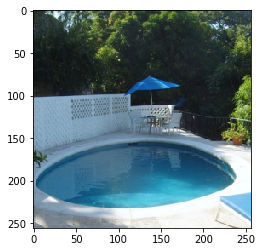

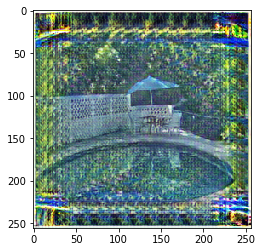

In [60]:
batch_size = 1

for batch, y_c in enumerate(train_loader):
    #y_c = data['image']
    original = y_c[:1,:,:,:]
    orig = original.detach().numpy()
    orig.shape = (3,256,256)
    orig = orig.transpose(1,2,0)
    plt.imshow(orig)
    plt.show()
    res = test(y_c[:1,:,:,:])       
    im = res.detach().numpy()
    im.shape = (3,256,256)
    im = im.transpose(1,2,0)
    plt.imshow(im)
    break
            
